## Final Capstone - Sentiment Analysis of Yelp Business Reviews

Part I: Data Wrangling & Exploratory Data Analysis

Biman Mondal

July 21, 2025

### Objective

<span style="color: blue; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
The objective of the final capstone is to perform sentiment analysis on customer reviews. The capstone's objective is to understand the nuance of performing natural language processing (NLP) and the various approaches. 
This notebook outlines the exploration of the dataset and to prepare the data for analysis.
</span>

### Import Libraries

In [85]:
# Import numpy package
import numpy as np
# Import pandas package
import pandas as pd
# Import matplotlib package
import matplotlib.pyplot as plt
# Import the seaborn package
import seaborn as sns

# Import time
import time
# Parallel processing
from multiprocessing import Pool, cpu_count
# Import operating system library
import os
import string
# Import tqdm to monitor for loop progress
from tqdm import tqdm 

# Import NLTK and all submodules
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Term frequency vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Import Spacy
import spacy
# Import Counter
from collections import Counter
# Import contractions
import contractions

In [ ]:
#!pip install -U numpy
#!pip install numpy==2.2.1
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#np.__version__
#pd.__version__
#plt.__version__
#!pip install --upgrade matplotlib
#!pip install --user matplotlib
#!pip uninstall matplotlib
#!pip install matplotlib numpy

In [ ]:
# Import natural language toolkit
# The following installs were required to use the NLTK library
#!pip install nltk
# import nltk
# download nltk corpus (first time only)
#nltk.download('all')
#help(nltk.stem)

In [35]:
# The following needed to be installed to use the spacy library
#!pip install spacy
#!pip install --upgrade --no-deps h5py 
# Reinstall h5py without reinstalling its dependencies
#!python -m spacy download en_core_web_sm
#!python -m spacy download en_core_web_sm
#import spacy
#!pip install contractions

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 345.1/345.1 kB 5.3 MB/s eta 0:00:00


<span style="color: red; font-family: Arial; font-size: 12px; background-color: #EEEEEE">
Both spacy and NLTK libraries required installation.<br />
Experienced some issues with matplotlib and numpy incompatibility with NLTK and Spacy libaraies. 
</span>

### Read dataframe

About the dataframe:\
The Yelp reviews dataset consists of reviews from Yelp. It is extracted from the Yelp Dataset Challenge 2015 data.\
http://www.yelp.com/dataset_challenge \
The dataset is sourced from hugging face.\
https://huggingface.co/datasets/Yelp/yelp_review_full \
The dataset consists of two .csv files: training.csv with 650k records and test.csv. with 50k records.


In [3]:
# Read Dataframe
df = pd.read_csv('../data/raw/yelp_review_fine-grained_5_classes_csv/train.csv', header='infer')

In [4]:
# Inspect the dataframe
df.head()
print(f"The dataframe has {df.shape[0]} rows and {df.shape[1]} columns.")
print(df.info())

The dataframe has 650000 rows and 2 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650000 entries, 0 to 649999
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   class_index  650000 non-null  int64 
 1   review_text  650000 non-null  object
dtypes: int64(1), object(1)
memory usage: 9.9+ MB
None


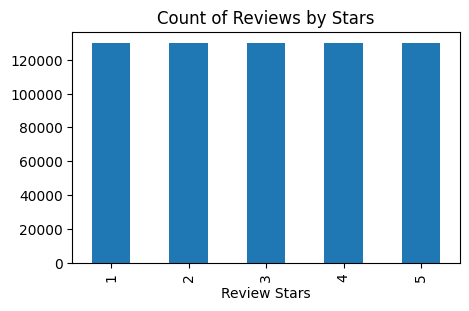

In [5]:
# Plot bar graph of the Review Stars
ax = df['class_index'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(5, 3))
ax.set_xlabel('Review Stars')
plt.show()

<span style="color: blue; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
The data is equally distributed by number of review stars.<br />
The dataset is free of any null values.<br /> 
There aren't any major data wrangling to perform other than text normalization. 
</span>

### Dataset Review Statistics

In [6]:
# Create a feature of the length of each review
df['review_length']=df['review_text'].apply(len)

In [7]:
# Average length of review is 732 characters
df['review_length'].describe()

count    650000.000000
mean        732.325468
std         663.721184
min           1.000000
25%         287.000000
50%         539.000000
75%         957.000000
max        5637.000000
Name: review_length, dtype: float64

In [8]:
def get_num_words(text_list):
    num_words = [len(word_tokenize(text.lower())) for text in tqdm(text_list)]
    return num_words

In [14]:
# Create a feature of the length of each review
'''
text_list = df['review_text'].to_list()
start = time.time()
num_words = get_num_words(text_list)
end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")
df['word_count'] = num_words
#word_tokenize(text.lower())
'''

100%|█████████████████████████████████████████████████████████████████████████| 650000/650000 [17:19<00:00, 625.51it/s]

Time elapsed: 17.3 min


<span style="color: blue; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
The above function which tokenizes and extracts text length of the reviews takes 17.3 minutes to run across the entire dataset. 
</span>

In [293]:
# Get random sample of reviews
#rand_review = df.sample(n=1)['review_text'].values.item()

In [299]:
# Subset of entire dataset
num_words = get_num_words(df.sample(n=1000)['review_text'])
# There are on average 154 words per review
#df['word_count'].describe()

100%|███████████████████████████████████████████| 10000/10000 [00:15<00:00, 647.86it/s]


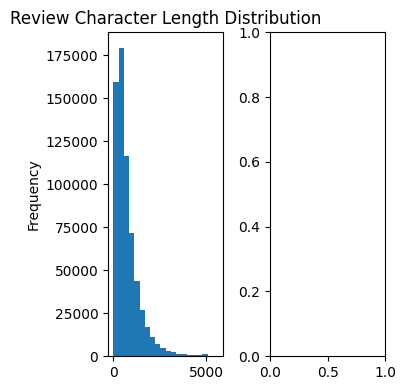

In [300]:
# Plot the character length and word length of the reviews
fig, axs = plt.subplots(1, 2, figsize =(6,6))
#
axs[0] = df['review_length']\
        .plot(kind='hist',bins=20,\
          title='Review Character Length Distribution',\
          ax=axs[0],figsize=(4, 4))
#ax[0].set_xlabel('Review Stars')
#
#axs[1] = df['word_count']\
#        .plot(kind='hist',bins=20,\
#          title='Review Word Length Distribution',\
#          ax=axs[1],figsize=(4, 4))
#ax[1].set_xlabel('Review Stars')
plt.tight_layout()
plt.show()

<span style="color: blue; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
The above plots show that the character length and word counts are both having right skewed distribution. The average reviews fall has 154 words with higher word count being less frequenct.
</span>

In [11]:
# Example Spacy 
#nlp = spacy.load("en_core_web_sm")
#text = preprocess_text(df.iloc[randnum.item(0)].review_text)
#doc = nlp(text)
#for token in doc:
#    print(token, token.lemma_)


### Sample a subset of the dataframe 

In [301]:
#Sample the dataframe with 0.5% of original records
df_sample = df.sample(frac=0.005,random_state=9, axis=0)

# Count the number of samples in each class
print(df_sample['class_index']\
                    .value_counts()\
                    .sort_index())
'''
# Plot the sampled review star distribution
ax = df_sample['class_index']\
                .value_counts()\
                .sort_index()\
                .plot(kind='bar',\
                title='Count of Sampled DF by Review Stars',\
                figsize=(4, 3))
ax.set_xlabel('Review Stars')
plt.show()
'''

class_index
1    654
2    653
3    652
4    657
5    634
Name: count, dtype: int64


"\n# Plot the sampled review star distribution\nax = df_sample['class_index']                .value_counts()                .sort_index()                .plot(kind='bar',                title='Count of Sampled DF by Review Stars',                figsize=(4, 3))\nax.set_xlabel('Review Stars')\nplt.show()\n"

In [294]:
# --- Helper function for parallel processing ---
def parallel_preprocess_series(my_function, text_to_process):
    """
    Applies preprocess_text to a pandas Series in parallel.
    """
    # Get the number of CPU cores available
    num_cores = 4#cpu_count()
    print(f"Using {num_cores} CPU cores for parallel processing.")

    # Create a pool of worker processes
    # The 'with' statement ensures the pool is properly closed
    with Pool(num_cores) as pool:
        # Map the preprocess_text function to each item in the series
        # pool.map returns results in the same order as the input
        processed_data = tqdm.tqdm(pool.map(my_function, text_to_process))
    return processed_data


## Text Normalization

Lowercasing converts all text to lowercase. 
Stop words are common words (e.g., "the," "a," "is," "and") that often carry little meaning on their own and don't contribute significantly to the sentiment of a sentence.
Noise removal involves cleaning up irrelevant characters, symbols, or formatting that do not contribute to the meaning or sentiment.

Tokenization is the process of breaking down a continuous text into smaller units called tokens. These tokens can be words, subwords, or even characters, depending on the specific tokenization strategy used.

Normalization is the process that brings words into standard format.
1) Stemming reduces words to their root form by chopping off suffixes (running -> run) however may lead to non-valid words (organization -> organizat).
2) Lemmatization is the process of reducing inflected forms of a word to its lemma, or base form, as found in a dictionary.


In [18]:
# create function to strip data frame of stop words and punctuation and lemmatize tokens
def preprocess_text(text):

    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words and punctuations in the tokens list
    stp_wrds_puncts = list()
    stp_wrds_puncts.append(string.punctuation)
    stp_wrds_puncts.extend(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stp_wrds_puncts]

    #stemmer = PorterStemmer('English')
    #stemmer = SnowballStemmer('english')
    #stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

In [ ]:
'''
# Linear to process text
text = df.iloc[randnum.item(0)].review_text
# Tokenize the text
tokens = word_tokenize(text.lower())

# Create a list of stopwords and punctuation
stp_wrds_puncts = list()
stp_wrds_puncts.append(string.punctuation)
stp_wrds_puncts.extend(stopwords.words('english'))

# Remove stop words and punctuations in the tokens list
filtered_tokens = [token for token in tokens if token not in stp_wrds_puncts]
filtered_tokens = ' '.join(filtered_tokens)
# Lemmatize the tokens using Spacy
nlp = spacy.load("en_core_web_sm")
#text = preprocess_text(df.iloc[randnum.item(0)].review_text)
lemmatized_tokens = [token.lemma_ for token in nlp(filtered_tokens)]

# Join the tokens back into a string
processed_text = ' '.join(lemmatized_tokens)
'''

### Run Lemmatization Script
Test serial vs. parallel processing

In [279]:
# Run preprocessing script serially
'''
start = time.time()
df_serial = df_sample.copy() # Work on a copy
df_serial['review_text_processed_serial'] = df_serial['review_text'].apply(preprocess_text)
end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")
df_serial.head()
'''

'\nstart = time.time()\ndf_serial = df_sample.copy() # Work on a copy\ndf_serial[\'review_text_processed_serial\'] = df_serial[\'review_text\'].apply(preprocess_text)\nend = time.time()\nprint(f"Time elapsed: {round((end - start)/60,1)} min")\ndf_serial.head()\n'

In [278]:
# Run preprocessing script in parallel
'''
start = time.time()
# Copy dataframe
df_parallel = df_sample.copy() # Work on a copy
# Perform preprocessing with parallel processing
df_parallel['review_text_processed_parallel'] = parallel_preprocess_series(df_parallel['review_text'])
end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")
df_parallel.head
'''

'\nstart = time.time()\n# Copy dataframe\ndf_parallel = df_sample.copy() # Work on a copy\n# Perform preprocessing with parallel processing\ndf_parallel[\'review_text_processed_parallel\'] = parallel_preprocess_series(df_parallel[\'review_text\'])\nend = time.time()\nprint(f"Time elapsed: {round((end - start)/60,1)} min")\ndf_parallel.head\n'

<span style="color: blue; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
The standard text normalization processing function which tokenizes and lemmatizes the reviews takes over 40 minutes to run just 1% of the dataset. Even when, changing the lemmatization to less accurate stemming method, the function could not process the entire dataset of reviews. Parallel processing the code did not improve run time.<br />
</span>
<span style="color: red; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
After several attempts, this procedure was abandoned.

### Normalize text reviews with Spacy
Test serial vs. parallel processing

In [297]:
 nlp = spacy.load("en_core_web_sm")

In [305]:
# create function to strip data frame of stop words and punctuation and lemmatize tokens
def preprocess_text_spacy(review_list):
    processed_text = list()
    for text in review_list:
        # Tokenize the text
        tokens = word_tokenize(text.lower())

        # Create a list of stopwords and punctuation
        stp_wrds_puncts = list()
        stp_wrds_puncts.append(string.punctuation)
        stp_wrds_puncts.extend(stopwords.words('english'))

        # Remove stop words and punctuations in the tokens list
        filtered_tokens = [token for token in tokens if token not in stp_wrds_puncts]
        filtered_tokens = ' '.join(filtered_tokens)
        # Lemmatize the tokens using Spacy
       
        #text = preprocess_text(df.iloc[randnum.item(0)].review_text)
        lemmatized_tokens = [token.lemma_ for token in nlp(filtered_tokens)]

        # Join the tokens back into a string
        #processed_text = ' '.join(lemmatized_tokens)
        processed_text.append(' '.join(lemmatized_tokens))

    return processed_text

In [ ]:
#textlist = df_serial.sample(n=4)['review_text'].values
#processed_list = preprocess_text_spacy(textlist)
'''
#Process values with for loop instead of using apply function within Pandas
start = time.time()
df_spacy = df_sample.copy()
review_list = df_spacy['review_text'].to_list()
processed_text = list()
for text in tqdm(review_list):
    processed_text.append(preprocess_text_spacy(text))
print("Loop completed")
end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")
df_spacy['review_text_processed_spacy'] = processed_text
'''

In [ ]:
'''
start = time.time()
# Get the number of CPU cores available
num_cores = 4 #cpu_count()
#print(f"Using {num_cores} CPU cores for parallel processing.")
# Create a pool of worker processes
# The 'with' statement ensures the pool is properly closed
with Pool(num_cores) as pool:
    # Map the preprocess_text function to each item in the series
    # pool.map returns results in the same order as the input
    myseries = df_sample.sample(n=10)['review_text'].values
    processed_data = pool.map(preprocess_text_spacy, myseries)
        
end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")
'''

<span style="color: blue; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
Running Spacy to perform normalization does not improve run times in comparison with NLTK. Running the code in parallel did not show run time improvement.
</span>

### BOW Frequency Count
Bag of words


In [308]:
sample_df = df.sample(n=1000)['review_text'].values.tolist()

#tokens = word_tokenize(text.lower())
#stp_wrds_puncts = list()
#stp_wrds_puncts.append(string.punctuation)
#stp_wrds_puncts.extend(stopwords.words('english'))
#processed_text = preprocess_text_spacy(my_sample)

In [29]:
'''
from sklearn.feature_extraction.text import CountVectorizer
# Count vectorizer
vectorizer = CountVectorizer()
# Matrix 
X = vectorizer.fit_transform(procesed_text)
# Word count
word_counts = np.sum(X.toarray(), axis=0)
# Words
words = vectorizer.get_feature_names_out()
#X.shape
#word_counts.shape
#my_tokens = [word_tokenize(text) for text in my_sample]
'''

In [203]:
def tokenize_count(text_list):
    # Create a count of tokenized text
    # Remove contractions and stop words
    token_list = list()
    for text in tqdm(text_list):
        # Tokenize the lowered text and fix contractions
        tokens = word_tokenize(contractions.fix(text.lower()))
        # Remove stop words and punctuations in the tokens list
        filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
        filtered_tokens = [token for token in filtered_tokens if token not in (string.punctuation or "''")]
        # Remove all non alpha numeric values like elipses '...' and empty strings
        filtered_tokens = [val for val in filtered_tokens if val.isalnum()]
        # Add to token list to be counted
        token_list.extend(filtered_tokens)
        # Counted Tokens
    return Counter(token_list)

In [309]:
start = time.time()

# Count the words
counted_tokens = tokenize_count(sample_df)
# Get the most common words out of list of tuples
words, count = zip(*counted_tokens.most_common(10))

end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")

100%|██████████████████████████████████████████████| 1000/1000 [00:45<00:00, 22.12it/s]

Time elapsed: 0.8 min


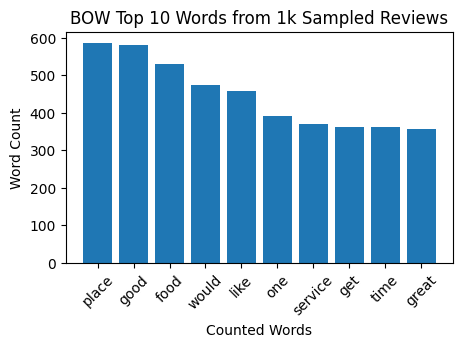

In [318]:
# Plot most common words
fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(x=words, height=count)
ax.set_xlabel('Counted Words')
ax.set_ylabel('Word Count')
ax.set_title('BOW Top 10 Words from 1k Sampled Reviews')
ax.tick_params(axis='x', labelrotation=45)
plt.show()

### TF-IDF

Term Frequency-Inverse Document Frequency method.\
Analyze meaningful words from sample text series.

In [311]:
def process_tfdif(text_list):
    # Create a count of tokenized text
    # Remove contractions and stop words
    nlp = spacy.load("en_core_web_sm")
    processed_text = list()
    for text in tqdm(text_list):
        # Tokenize the lowered text and fix contractions
        tokens = word_tokenize(contractions.fix(text.lower()))
        # Remove stop words and punctuations in the tokens list
        filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
        filtered_tokens = [token for token in filtered_tokens if token not in (string.punctuation or "''")]
        # Remove all non alpha numeric values like elipses '...' and empty strings
        filtered_tokens = [val for val in filtered_tokens if val.isalnum()]
        filtered_text = ' '.join(filtered_tokens)
        # Lemmatize tokens
        lemmatized_tokens = [token.lemma_ for token in nlp(filtered_text)]
        # Lemmatized text
        lemmatized_text = ' '.join(lemmatized_tokens)

        # Add to token list to be counted
        processed_text.append(lemmatized_text)    

    return processed_text

In [312]:
# Process text for TFIDF analysis
start = time.time()
text = process_tfdif(sample_df)
end = time.time()
print(f"Time elapsed: {round((end - start)/60,1)} min")

100%|██████████████████████████████████████████████| 1000/1000 [01:15<00:00, 13.33it/s]

Time elapsed: 1.3 min


In [313]:
# TFIDF vectorizer
vectorizer = TfidfVectorizer()
# Fit transform
tfidf_matrix = vectorizer.fit_transform(text)
# Convert sparse matrix to an array
tfidf_dense = tfidf_matrix.toarray()
print(tfidf_dense.shape)
# Get out word list from fit
tfidf_feature_names = vectorizer.get_feature_names_out()

(1000, 7716)


In [314]:
# Convert to Pandas dataframe

# The matrix of TF-IDF creates a matrix columns associated with the words and
# rows designate their score
df_tfidf = pd.DataFrame(
                tfidf_dense,
                columns = tfidf_feature_names
                )
df_tfidf.head(5)

,10,100,1000,1000w,100x,101,1030am,104th,105,10p,...,zealous,zen,zero,zesty,zigzag,zip,zizzo,zomg,zone,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [315]:
# Extract the normalized tfidf score
col_norm = list()
for col in df_tfidf.columns:
    col_norm.append(np.linalg.norm(df_tfidf[col]))

# Get the descending sort on the normalized scores
sorted_scores = np.sort(col_norm)[::-1]
sorted_indices = np.argsort(col_norm)[::-1]
print("sorted normalized scores: \n", sorted_scores)
print("sorted indicies: \n",sorted_indices)

# Significant words based on sorted values
significant_words = df_tfidf.columns[sorted_indices]
#significant_word_count = df_tfidf.sum(axis=1).\
#                    sort_values(ascending=False)
#significant_words = df_tfidf.columns[significant_word_count.index]

sorted normalized scores: 
 [2.22144244 2.07500109 1.97461162 ... 0.03144102 0.03144102 0.03144102]
sorted indicies: 
 [3037 2982 2727 ... 5894 4278   34]


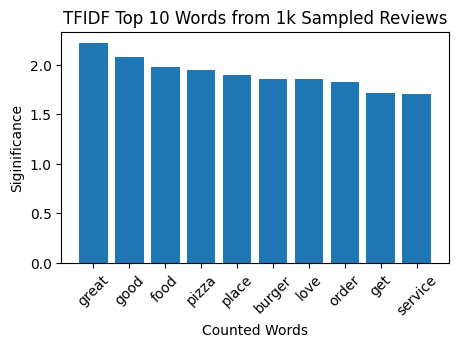

In [317]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(x=significant_words[:10], height=sorted_scores[:10])
ax.set_xlabel('Counted Words')
ax.set_ylabel('Siginificance')
ax.set_title('TFIDF Top 10 Words from 1k Sampled Reviews')
ax.tick_params(axis='x', labelrotation=45)
plt.show()

<span style="color: blue; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
Performing bag of words (BOW) and term frequency-inverse term frequency (TF-IDF) on the same review sample set results in uniquely different list of words. The normalized score from the TF-IDF provides a list of more significant and meaningful descriptor of reviews. 
</span>

## Summary
<span style="color: blue; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
The dataset from hugging face used for sentiment analysis has 650k records with review text and rating (1-5). The first attempt to lemmatize the text using NLTK was extremely slow. The processing speed was nearly an hour. Downsampling the original dataframe to 0.05% of the records lead to over a half-hour run time to preprocess and normalize the text.<br />
<span style="color: blue; font-family: Arial; font-size: 16px; background-color: #EEEEEE">    
Running the analysis in parallel did not improve run times.
In an attempt to provide results, a sample of the dataset was used to perform BOW and TFIDF of the reviews. In the following part of the analysis, the full dataset analysis will be provided.<br />
</span>
<span style="color: red; font-family: Arial; font-size: 16px; background-color: #EEEEEE">
Note that several sections of this notebook have been block commented so the script can complete running within a few minutes instead of hours. 